# **Sentiment Analysis**
## Topics
* data Cleaning
* Tokenization
* embedding
* transfer learning
* LTSM GRU
* data visualization

In [1]:
import tensorflow as tf

import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

from nltk.corpus import stopwords

import string
import pandas as pd
import numpy as np
import emoji
from wordcloud import WordCloud
import re
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

assert tf.__version__ >= "2.0"

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [2]:
# Data paths
EMBEDDING_PATH = "./data/glove.6B.50d.txt"
COMMENT_PATH = "./data/tripadvisor_hotel_reviews.csv"

# Global variable
VOCAB_SIZE = 20000
NUM_OOV_BUCKETS = 2000
MAXLEN=300

stopwords = stopwords.words("english")

### Data exploration

In [3]:
df = pd.read_csv(COMMENT_PATH)

In [6]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
df.shape

(20491, 2)

In [7]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

<AxesSubplot:>

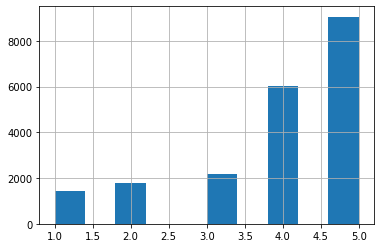

In [9]:
df.Rating.hist()

In [17]:
def wordCloud_generator(data, title=None):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords,
                          width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

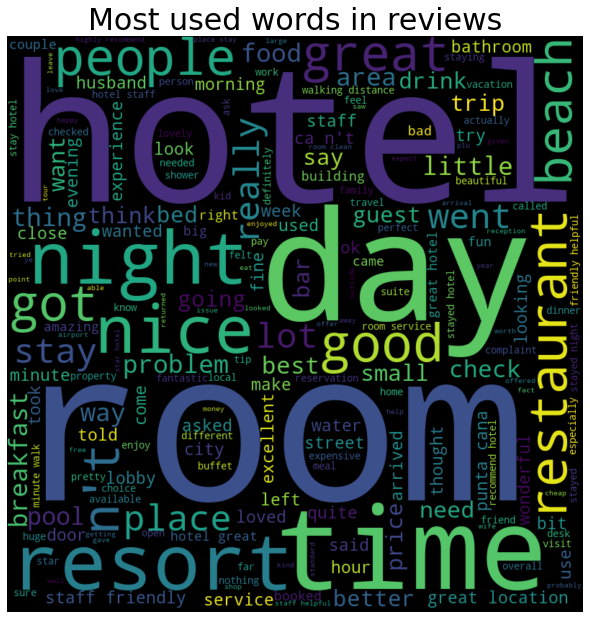

In [18]:
wordCloud_generator(df.Review, title="Most used words in reviews")

### Data cleaning

In [4]:
def preprocess_classic(review):
    """
    * remove punctuation
    * set to lowercase
    * remove stop words
    * split text
    * tokenize
    * padding
    """
    review = re.sub("(?<! )(?=[.,!?()/'])|(?<=[.,!?()/'])(?! )", r' ', review)
    review = ''.join([word for word in review if not word.isdigit()])
    review = ''.join([i for i in review if not i in string.punctuation])
    review = ''.join(review).lower()
    review = " ".join([word for word in review.split() if not word in stopwords])
    
    #ratings_set = tf.one_hot(ratings, 5, on_value=1.0, off_value = 0.0)
    return review

In [12]:
preprocess_classic("This was an amazing trip!! hope you will like it")

'amazing trip hope like'

In [5]:
def tokenizing(X_cleaned, tokenizer, maxlen = MAXLEN):

    X = tokenizer.texts_to_sequences(X_cleaned)
    X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=maxlen)
    return X

In [6]:
X = df['Review'].copy()
y = df['Rating'].copy()

X.apply(preprocess_classic)

tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X)

# encode labels
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }

labels = ['1', '2', '3', '4', '5']
           
y.replace(encoding, inplace=True)



## Transfer learning Model
Uiversal sentence encoder

**Split train/test**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)
print(X_train[1], y_train[1])

ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman bus

**Embedding layer from universal sentence encoder**

In [30]:
embedding= "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

**Model**

In [31]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation="softmax")) # essayer avec sigmoid

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_TL = model.fit(X_train, y_train,
                    epochs=5,
                    validation_split=0.12,
                    verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_19 (Dense)             (None, 16)                8208      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 85        
Total params: 256,806,117
Trainable params: 256,806,117
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
378/378 [==============================] - 41s 109ms/step - loss: 1.0037 - accuracy: 0.5660 - val_loss: 0.8623 - val_accuracy: 0.6165
Epoch 2/5
378/378 [==============================] - 41s 110ms/step - loss: 0.5042 - accuracy: 0.8069 - val_loss: 0.8932 - val_accuracy: 0.6232
Epoch 3/5
378/378 [==============================] - 41s 108ms/step - loss: 0.1629

**History**

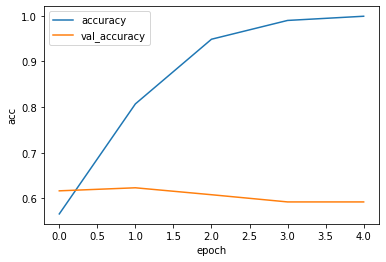

In [35]:
plt.plot(history_TL.history["accuracy"], label='accuracy')
plt.plot(history_TL.history["val_accuracy"], label='val_accuracy')

plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

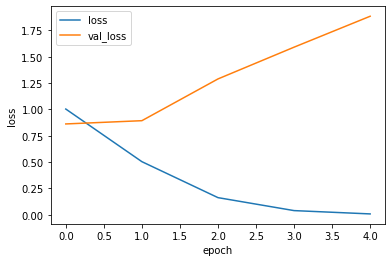

In [36]:
plt.plot(history_TL.history["loss"], label='loss')
plt.plot(history_TL.history["val_loss"], label='val_loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

**Evaluation**

In [38]:
model.evaluate(X_test, y_test, verbose = 1, batch_size=32)

212/212 [==============================] - 4s 19ms/step - loss: 1.8713 - accuracy: 0.5954


[1.8713147640228271, 0.5954458117485046]

**Prediction**

In [48]:
pred = model.predict_classes(X_test, batch_size=32, verbose = 1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


212/212 [==============================] - 4s 19ms/step


**Classification report**

In [49]:
v = metrics.classification_report(y_test, pred, target_names= labels)
print(v)

              precision    recall  f1-score   support

           1       0.86      0.23      0.36       469
           2       0.42      0.59      0.49       592
           3       0.44      0.36      0.39       721
           4       0.49      0.66      0.56      1993
           5       0.79      0.67      0.72      2988

    accuracy                           0.60      6763
   macro avg       0.60      0.50      0.51      6763
weighted avg       0.64      0.60      0.60      6763



**Confusion matrix**

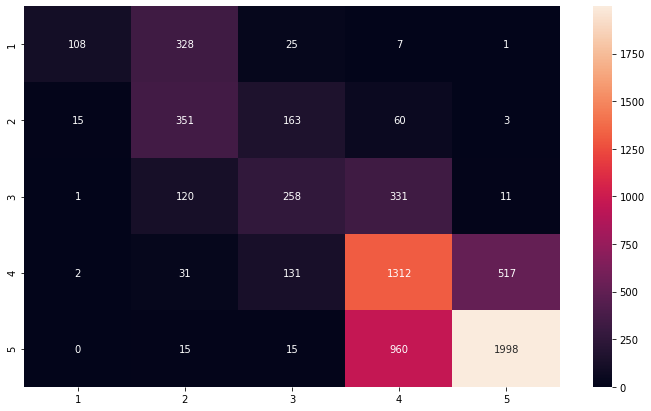

In [50]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

**Save**

In [53]:
model.save("./Model/model_with_TL.h5")

**Play with custom review**

In [51]:
print(model.predict(["this was an amazing trip"])*100)

[[1.0809125e-02 9.5495507e-03 3.1807423e-03 1.4023484e-01 9.9836227e+01]]


## Custom model


**Split test/train and tokenize reviews**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

X_train = tokenizing(X_train, tokenizer)

print(X_train[2], y_train[2])

[    4    26    19    73  1717     4     1    12  1374   185   115    95
   318     4  3064 13598    29   496  2781  3285  1931    17     7    27
    31   107 19932     6   142   631   143    90   903   751  3280   308
     4  2057   113    50   573    92   128 10397  2530   563    28    14
  1763  1175   128    89    92 19932   302     5  4375   107   255    41
   629   286   300   254  1970   328   145   281    45   368    19     5
     4     6   237   234   629    35   989  1709  4624  1970 50210   300
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [25]:
# hyper parameters
EPOCHS = 10
BATCH_SIZE = 100
embedding_dim = 16
vocab_size = len(tokenizer.word_index)+1

model = tf.keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=X_train.shape[1]),
    keras.layers.Bidirectional(keras.layers.LSTM(40,return_sequences=True)),
    #L.LSTM(units,return_sequences=True),
    keras.layers.Conv1D(64,3),
    keras.layers.MaxPool1D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation="softmax")
])


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE, verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 16)           835376    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 300, 80)           18240     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 298, 64)           15424     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 149, 64)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9536)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 9536)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)              

In [20]:

EPOCHS = 3
BATCH_SIZE = 100
embedding_dim = 16
vocab_size = len(tokenizer.word_index)+1

inp = keras.layers.Input(shape = [None])
x = keras.layers.Embedding(vocab_size, embedding_dim)(inp)
x = keras.layers.SpatialDropout1D(0.5)(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(40, return_sequences=True))(x)
x = keras.layers.Bidirectional(keras.layers.GRU(40, return_sequences=True))(x)
avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
conc = keras.layers.concatenate([avg_pool, max_pool])
outp = keras.layers.Dense(5, activation = 'softmax')(conc)

model = keras.Model(inputs = inp, outputs = outp)
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size = BATCH_SIZE,
                    epochs=5,
                    validation_split=0.12,
                    verbose=1)

Epoch 1/5
121/121 [==============================] - 64s 533ms/step - loss: 1.3652 - accuracy: 0.4361 - val_loss: 1.1715 - val_accuracy: 0.4697
Epoch 2/5
121/121 [==============================] - 65s 539ms/step - loss: 1.0019 - accuracy: 0.5500 - val_loss: 0.9099 - val_accuracy: 0.5819
Epoch 3/5
121/121 [==============================] - 65s 541ms/step - loss: 0.8645 - accuracy: 0.6165 - val_loss: 0.8886 - val_accuracy: 0.5941
Epoch 4/5
121/121 [==============================] - 63s 524ms/step - loss: 0.7734 - accuracy: 0.6597 - val_loss: 0.8771 - val_accuracy: 0.6032
Epoch 5/5
121/121 [==============================] - 65s 537ms/step - loss: 0.6976 - accuracy: 0.6982 - val_loss: 0.9077 - val_accuracy: 0.6001


**History**

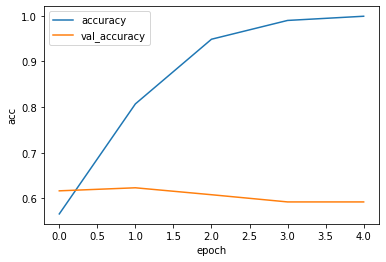

In [56]:
plt.plot(history_TL.history["accuracy"], label='accuracy')
plt.plot(history_TL.history["val_accuracy"], label='val_accuracy')

plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

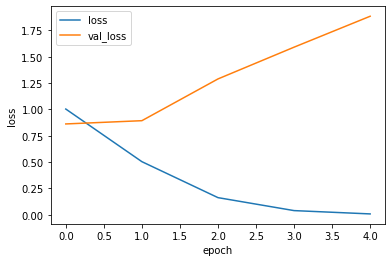

In [57]:
plt.plot(history_TL.history["loss"], label='loss')
plt.plot(history_TL.history["val_loss"], label='val_loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

**Evaluation**

In [59]:
X_test = tokenizing(X_test, tokenizer)

loss, acc = model.evaluate(X_test, y_test, verbose = 1, batch_size=32)

print()
print("Test accuracy = ", acc)

212/212 [==============================] - 3s 16ms/step - loss: 0.8990 - accuracy: 0.6056

Test accuracy =  0.605648398399353


**Prediction**

In [65]:
pred = model.predict(X_test, batch_size=32, verbose = 1)

212/212 [==============================] - 3s 15ms/step


**Classification report**

In [71]:
print(metrics.classification_report(y_test, np.argmax(pred, axis=1), target_names=labels))

              precision    recall  f1-score   support

           1       0.59      0.64      0.62       469
           2       0.41      0.39      0.40       592
           3       0.38      0.26      0.31       721
           4       0.51      0.55      0.53      1993
           5       0.75      0.76      0.76      2988

    accuracy                           0.61      6763
   macro avg       0.53      0.52      0.52      6763
weighted avg       0.60      0.61      0.60      6763



**Confusion matrix**

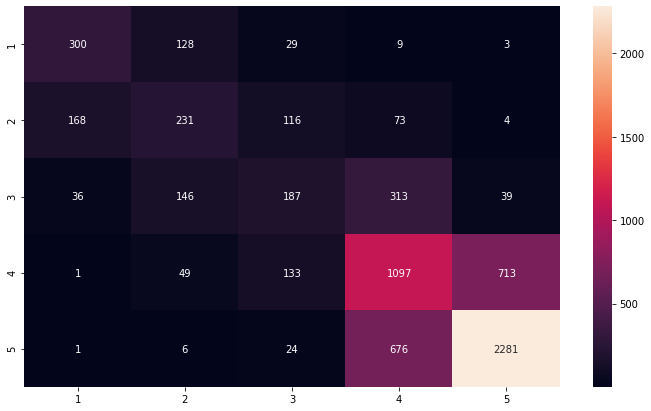

In [72]:
conf = confusion_matrix(y_test, np.argmax(pred, axis=1))

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

**Save model**

In [21]:
model.save("./Model/custom_model.h5")

tf.saved_model.save(model, "./Model/custom/custom_model001")